BUILDING A FX QUANTITATIVE SYSTEM

FX trading is one of most competitive markets in the world. Besides other financial instruments, FX makes traditional portfolio managers name it gambling as its difficulty in prediction and high volatility. 

To make it simple we have two approaches when it comes to trading, trend or contra-trend, also called mean reversion strategies. FX it's very corrective, however when a strong trend starts caused by any macroeconomic factor you better surf the trend and not fight against it if you want to survive.

In this notebook I'll expalin my fundamental approach to FX quantitative trading. First we will simplify 45 pairs to 10 currency indices, which will allow us to observe the market desegmented and catch easier the trending pairs and the corrective ones.

Through this notebook I'll explain step by step each process and its logic. Hope you enjoy it.

In [3]:

# import libraries
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
from os import listdir
import pandas as pd
from pathlib import Path
import plotly.express as px
import seaborn as sns
import scipy.signal as signal
from datetime import datetime

# create a file named key.py with token = 'your_oanda_token'
import key

client = API(access_token=key.token)

In order to don't charge to much our pc's RAM we'll create a local database (db) of all the symbols to be analyzed and traded. Each instrument will have it's own csv file and its timeframe folder. It will help later to backtest our model as well.

In [74]:
path = 'db/instruments' # path where to download history data


symbols = ['AUD_CAD', 'AUD_CHF', 'AUD_HKD', 'AUD_JPY', 'AUD_NZD', 'AUD_SGD', 'AUD_USD',
           'CAD_CHF', 'CAD_HKD', 'CAD_JPY', 'CAD_SGD', 'CHF_HKD', 'CHF_JPY', 'EUR_AUD',
           'EUR_CAD', 'EUR_CHF', 'EUR_GBP', 'EUR_HKD', 'EUR_JPY', 'EUR_NZD', 'EUR_SGD',
           'EUR_USD', 'GBP_AUD', 'GBP_CAD', 'GBP_CHF', 'GBP_HKD', 'GBP_JPY', 'GBP_NZD',
           'GBP_SGD', 'GBP_USD', 'HKD_JPY', 'NZD_CAD', 'NZD_CHF', 'NZD_HKD', 'NZD_JPY',
           'NZD_SGD', 'NZD_USD', 'SGD_CHF', 'SGD_HKD', 'SGD_JPY', 'USD_CAD', 'USD_CHF',
           'USD_HKD', 'USD_JPY', 'USD_SGD'] # 45 fx pairs

timeframe = 'D'

from datetime import timedelta, date

def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

start_dt = date(2010,1,1)
end_dt  = date(2010,12,31)


def oanda_candles():
    weekdays = [5,6]
    for dt in daterange(start_dt, end_dt):
        if dt.weekday() not in weekdays:
            date = dt.strftime("%Y-%m-%d")
            params = { 'granularity': 'D', 'from': date, 'to': date}
            for sym in symbols:
                r = instruments.InstrumentsCandles(sym, params)
                r = client.request(r)
                print(sym, date, r['candles'])


        

oanda_candles()


AUD_CAD 2010-01-01 [{'complete': True, 'volume': 6, 'time': '2009-12-31T22:00:00.000000000Z', 'mid': {'o': '0.94570', 'h': '0.94593', 'l': '0.94539', 'c': '0.94593'}}]
AUD_CHF 2010-01-01 [{'complete': True, 'volume': 5, 'time': '2009-12-31T22:00:00.000000000Z', 'mid': {'o': '0.92924', 'h': '0.92960', 'l': '0.92908', 'c': '0.92934'}}]
AUD_HKD 2010-01-01 [{'complete': True, 'volume': 8, 'time': '2009-12-31T22:00:00.000000000Z', 'mid': {'o': '6.96063', 'h': '6.96372', 'l': '6.95947', 'c': '6.96169'}}]
AUD_JPY 2010-01-01 [{'complete': True, 'volume': 14, 'time': '2009-12-31T22:00:00.000000000Z', 'mid': {'o': '83.463', 'h': '83.555', 'l': '83.463', 'c': '83.555'}}]
AUD_NZD 2010-01-01 [{'complete': True, 'volume': 3, 'time': '2009-12-31T22:00:00.000000000Z', 'mid': {'o': '1.24222', 'h': '1.24222', 'l': '1.24153', 'c': '1.24153'}}]
AUD_SGD 2010-01-01 [{'complete': True, 'volume': 11, 'time': '2009-12-31T22:00:00.000000000Z', 'mid': {'o': '1.26114', 'h': '1.26160', 'l': '1.26090', 'c': '1.2609

KeyboardInterrupt: 

In [33]:
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
from datetime import timedelta, date
from pathlib import Path
from numpy import isnan
import pandas as pd

import key

client = API(access_token=key.token)

symbols = ['AUD_CAD', 'AUD_CHF', 'AUD_HKD', 'AUD_JPY', 'AUD_NZD', 'AUD_SGD', 'AUD_USD',
           'CAD_CHF', 'CAD_HKD', 'CAD_JPY', 'CAD_SGD', 'CHF_HKD', 'CHF_JPY', 'EUR_AUD',
           'EUR_CAD', 'EUR_CHF', 'EUR_GBP', 'EUR_HKD', 'EUR_JPY', 'EUR_NZD', 'EUR_SGD',
           'EUR_USD', 'GBP_AUD', 'GBP_CAD', 'GBP_CHF', 'GBP_HKD', 'GBP_JPY', 'GBP_NZD',
           'GBP_SGD', 'GBP_USD', 'HKD_JPY', 'NZD_CAD', 'NZD_CHF', 'NZD_HKD', 'NZD_JPY',
           'NZD_SGD', 'NZD_USD', 'SGD_CHF', 'SGD_HKD', 'SGD_JPY', 'USD_CAD', 'USD_CHF',
           'USD_HKD', 'USD_JPY', 'USD_SGD'] # 45 fx pairs

def importdb( year, symbols ):

    # prepare dataframe
    def prepdf( year ):

        def daterange(date1, date2):
            for n in range(int ((date2 - date1).days)+1):
                yield date1 + timedelta(n)

        start_dt = date(year,1,1)
        end_dt = date(year,12,31)

        dates = []
        weekdays = [5,6]
        for dt in daterange(start_dt, end_dt):
            if dt.weekday() not in weekdays:
                dates.append(dt.strftime("%Y-%m-%d"))

        return pd.DataFrame(index=dates, columns=symbols)

    y = year
    more = True
    while more:

        prices = prepdf(y)
        changs = prepdf(y)
        volats = prepdf(y)   

        _from = str(y)+'-01-01'
        _to   = str(y)+'-12-31'
        # if it's current year
        if y == datetime.today().year:
            _to = str(datetime.today())[0:10]
            prices = prices.truncate(after=_to)
            changs = changs.truncate(after=_to)
            volats = volats.truncate(after=_to)
            more = False

        params = { 'granularity': 'D', 'from': _from, 'to': _to}

        # import from oanda
        for sym in symbols:
            r = instruments.InstrumentsCandles(sym, params)
            r = client.request(r)
            for p in r['candles']:
                dtime  = datetime.strftime(datetime.strptime(p['time'][0:10], '%Y-%m-%d') + timedelta(days=1), '%Y-%m-%d')
                price = round( ( float(p['mid']['o']) + float(p['mid']['h']) + float(p['mid']['l']) + float(p['mid']['c']) ) / 4, len(p['mid']['c'].split('.')[1]) )
                chang = round( ( float(p['mid']['c']) / float(p['mid']['o']) -1 ) * 100, 2 )
                volat = round( ( float(p['mid']['h']) / float(p['mid']['l']) -1 ) * 100, 2 )
                prices[sym][dtime] = price
                changs[sym][dtime] = chang
                volats[sym][dtime] = volat

        # clean nans
        for sym in symbols:
            changs[sym] = changs[sym].fillna(0)
            volats[sym] = volats[sym].fillna(0)
            for i in range(len(prices.index)):
                if isnan(prices[sym][i]):
                    try:
                        prices[sym][i] = prices[sym][i-1]
                    except:
                        prices[sym][i] = prices[sym][i+1]

        # create db
        path = 'db/instruments/'+str(y)+'/'
        Path(path).mkdir(parents=True, exist_ok=True)
        prices.to_csv(path+'prices.csv', index=True)
        changs.to_csv(path+'changs.csv', index=True)
        volats.to_csv(path+'volats.csv', index=True)

        print(y, ' upadted!' )

        y += 1


importdb( 2020, symbols )
    




2020  upadted!
2021  upadted!
2022  upadted!


2022-06-12


Now that we have all the instruments in our folder ( ./db/instruments/'timeframe'/ ) we'll create a function to extract each currency index. The idea is simple: if we want to see the AUD movements, we'll take all the returns in the AUD pairs. I.e: AUD/CAD + AUD/JPY + 1/(EUR/AUD) + ...

In [195]:

def index(currency):

    print('Creating '+currency+'...')
    
    files = [k for k in listdir('db/instruments/'+timeframe) if currency in k]
    df = pd.read_csv('db/instruments/'+timeframe+'/'+files[0])

    if files[0][0:3] != currency:
        df['return'] = -df['return']
    df = df.rename(columns={'return': files[0][0:7]})

    for i in range(1, len(files)):
        df2 = pd.read_csv('db/instruments/'+timeframe+'/'+files[i])
        if files[i][0:3] != currency:
            df2['return'] = -df2['return']
        df2 = df2.rename(columns={'return': files[i][0:7]})
        df = pd.merge(df, df2, on=['date', 'date'])

    df = df.fillna(0)
    df = df.set_index('date')

    df[currency] = round(df.sum(axis=1)/len(currencies), 2)
    df = df[currency]
    Path('db/indexes/'+timeframe).mkdir(parents=True, exist_ok=True)
    df.to_csv('db/indexes/'+timeframe+'/'+currency+'.csv', index=True)


currencies = ['AUD', 'CAD', 'CHF', 'EUR', 'GBP', 'JPY', 'NZD', 'SGD', 'USD']

for curr in currencies:
    index(curr)



Creating AUD...
Creating CAD...
Creating CHF...
Creating EUR...
Creating GBP...
Creating HKD...
Creating JPY...
Creating NZD...
Creating SGD...
Creating USD...


We have created the FX G10 currency indices. Meaning that now we can observe each currency by separate. Let's plot it and see the correlation between them.

In [196]:
idx = pd.read_csv('db/indexes/'+timeframe+'/'+currencies[0]+'.csv')
idx[currencies[0]] = idx[currencies[0]].cumsum()
for i in range(1, len(currencies)):
    df2 = pd.read_csv('db/indexes/'+timeframe+'/'+currencies[i]+'.csv')
    df2[currencies[i]] = df2[currencies[i]].cumsum()
    idx = pd.merge(idx, df2, on=['date', 'date'])

pd.options.plotting.backend = "plotly"
plt = idx.plot(x='date', y=currencies, height=900)
plt.show()


In [197]:
def LowPass(currency):
    # buterworth filter parameters
    N = 2  # filter order
    Wn = 0.1  # cutoff frequency
    B, A = signal.butter(N, Wn, output='ba')
    # get currency index from db
    df = pd.read_csv('db/indexes/'+timeframe+'/'+currency+'.csv')
    # cumulative sum to create trend
    df[currency] = round(df[currency].cumsum(), 2)
    # apply lowpass filter
    df[currency] = signal.filtfilt(B, A, df[currency])
    return df


sig = LowPass(currencies[0])
for i in range(1,len(currencies)):
    sig = pd.merge(sig, LowPass(currencies[i]), on=['date', 'date'])


plt = sig.plot(title='Signal', x='date', y=currencies, height=600)
plt.show()

idx = idx.set_index('date')
sig = sig.set_index('date')

noise = idx.subtract(sig)

plt = noise.plot(title='Noise', x=noise.index, y=noise.columns, height=600)
plt.show()



In [198]:
matrix = idx.corr()
sns.set(rc={'figure.figsize':(11.7,8.27)})
hm1 = sns.heatmap(matrix, annot=True)
hm1.set(title="RAW - FX G10 Correlation Matrix\n")


[Text(0.5, 1.0, 'RAW - FX G10 Correlation Matrix\n')]

As we can oberseve some pairs that are currently very correlated, like USD/HKD or SGD/HKD or even EUR/JPY. It can be for multiple reasons, mainly caused by monetary policies. However, all this pairs are perfect for playing mean-reversion strategies. As both currencies are correlated the volatility of the pair will be low, that's why we call it beta pairs.

On the other hand, we have another class of pairs that are negatively correlated. These pairs will be more trendy, as their currencies are going on opposite directions. We'll look for signals to join the trend. We call it alpha pairs as are the most volatile ones.

Last we have the gamma pairs, which are uncorrelated (close to 0). The currencies compounding these pairs have a random relation apparently. Which are perfect for building an uncorrelated portfolio, we can look for trend or corrections.

In [199]:
beta = [] # pairs correlated above 0.75 -> which will be the corrective ones.
alpha = [] # pairs negative correlated below -0.75 -> which will be the tren ones.
gamma = [] # pairs uncorrelated between -0.25 and 0.25 -> which will be the ones we will use to uncorrelated our portfolio in the risk management section.

for base in currencies:
    for term in currencies:
        if base != term:
            if matrix[base][term] > 0.75:
                beta.append(base + '_' + term)
            elif matrix[base][term] < -0.75:
                alpha.append(base + '_' + term)
            elif matrix[base][term] > -0.2 and matrix[base][term] < 0.2:
                gamma.append(base + '_' + term)


beta = [ x for x in beta if x in symbols ]
alpha = [ x for x in alpha if x in symbols ]
gamma = [ x for x in gamma if x in symbols ]


print('\nbeta:', beta, '\nalpha:', alpha, '\ngamma:',gamma)


beta: ['USD_HKD'] 
alpha: ['AUD_HKD', 'AUD_USD', 'CAD_CHF', 'CHF_JPY'] 
gamma: ['AUD_CHF', 'AUD_JPY', 'AUD_SGD', 'CHF_HKD', 'EUR_CHF', 'GBP_CAD', 'GBP_CHF', 'GBP_NZD', 'GBP_SGD', 'HKD_JPY', 'SGD_HKD', 'USD_CHF', 'USD_SGD']


[-0.00116417 -0.00139094  0.00195951  0.00293134 -0.00437535 -0.00637313
  0.00902803  0.01248116 -0.0169409  -0.02273977  0.03045372  0.04118039
 -0.05729369 -0.08500841  0.14720004  0.45005217  0.45005217  0.14720004
 -0.08500841 -0.05729369  0.04118039  0.03045372 -0.02273977 -0.0169409
  0.01248116  0.00902803 -0.00637313 -0.00437535  0.00293134  0.00195951
 -0.00139094 -0.00116417]


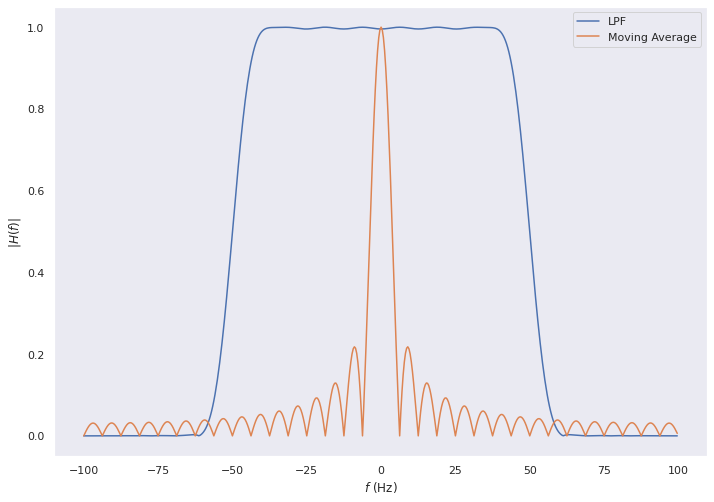

In [201]:
from pylab import *
from scipy.signal import firwin
from pylab import arange, ones


Fs = 200.

N = 32
h_lpf = firwin(N, 50, nyq=Fs/2., window='hamming')
h_ma = ones(N)*1./N

print(h_lpf)

M = 512


X_lpf = fftshift(abs(fft(h_lpf, M)))
X_lpf /= X_lpf.max()
X_ma = fftshift(abs(fft(h_ma, M)))
X_ma /= X_ma.max()

f = arange(M)*Fs/M - Fs/2.

figure()
plot(f, X_lpf, f, X_ma)
xlabel('$f$ (Hz)')
ylabel('$|H(f)|$')
legend(('LPF', 'Moving Average'))
grid()
show()

In [217]:
def low_pass_weights(series, window, cutoff):
    """Calculate weights for a low pass Lanczos filter.

    Args:

    window: int
        The length of the filter window.

    cutoff: float
        The cutoff frequency in inverse time steps.

    """
    order = ((window - 1) // 2 ) + 1
    nwts = 2 * order + 1
    w = np.zeros([nwts])
    n = nwts // 2
    w[n] = 2 * cutoff
    k = series
    sigma = np.sin(np.pi * k / n) * n / (np.pi * k)
    firstfactor = np.sin(2. * np.pi * cutoff * k) / (np.pi * k)
    w[n-1:0:-1] = firstfactor * sigma
    w[n+1:-1] = firstfactor * sigma
    return w[1:-1]


df = low_pass_weights(idx['AUD'][0:60],121, 1. / 24.) 

idx['AUD'][0:60]


date
2008-06-08T21:00:00    12.53
2008-06-09T21:00:00    12.72
2008-06-10T21:00:00    12.49
2008-06-11T21:00:00    11.80
2008-06-12T21:00:00    12.42
2008-06-15T21:00:00    12.29
2008-06-16T21:00:00    12.45
2008-06-17T21:00:00    12.63
2008-06-18T21:00:00    12.99
2008-06-19T21:00:00    12.97
2008-06-22T21:00:00    13.22
2008-06-23T21:00:00    13.33
2008-06-24T21:00:00    13.55
2008-06-25T21:00:00    12.94
2008-06-26T21:00:00    13.12
2008-06-29T21:00:00    12.98
2008-06-30T21:00:00    12.68
2008-07-01T21:00:00    13.06
2008-07-02T21:00:00    13.38
2008-07-03T21:00:00    13.67
2008-07-05T21:00:00    13.67
2008-07-06T21:00:00    13.20
2008-07-07T21:00:00    13.12
2008-07-08T21:00:00    13.04
2008-07-09T21:00:00    13.50
2008-07-10T21:00:00    13.51
2008-07-12T21:00:00    13.70
2008-07-13T21:00:00    13.78
2008-07-14T21:00:00    14.02
2008-07-15T21:00:00    13.83
2008-07-16T21:00:00    13.85
2008-07-17T21:00:00    13.84
2008-07-18T21:00:00    13.84
2008-07-19T21:00:00    13.97
2008-07-2